# Training a U-Net with PyTorch on SageMaker
In this notebook you'll see how to train a U-Net with a synthetic dataset using SageMaker. We'll use a public implementation of the model, published to https://github.com/milesial/Pytorch-UNet. Our goal here is not to change the original code, but only apply minimal adjustments to point it to the correct directories used by SageMaker.

**Dataset**: We'll prepare a synthetic dataset for semantic segmentation using OpenCV. The dataset is basicaly a background noise with random geometric shapes rendered on top. The masks will correspond to the geometric shapes.

For this exercise, wel'll have only two classes in our dataset: 0 - Background, 1 - Shape

# 1) Clone the repo and adjust the training file for SageMaker

SageMaker uses the dir **/opt/ml/......** to manage files: datasets, checkpoints, logs, trained models, etc. So, we need to change some hardcoded parameters in the training script to point it to the correct directories used by SageMaker

In [ ]:
import os
import shutil
if os.path.isdir('src'): shutil.rmtree('src')
!git clone https://github.com/milesial/Pytorch-UNet src && cd src && git checkout 2f62e6b

## Adjusting the paths to make it aligned with SageMaker
!sed -i "s#'./data/imgs/'#'/opt/ml/input/data/train/imgs/'#" src/train.py
!sed -i "s#'./data/masks/'#'/opt/ml/input/data/train/masks/'#" src/train.py
!sed -i "s#'./checkpoints/'#'/opt/ml/model/'#" src/train.py
## Only the last checkpoint will be kept
## For a more elaborated mechanis, you'll need to edit src/train.py
!sed -i "s#'checkpoint_epoch{}.pth'.format(epoch)#'model.pt'#" src/train.py

## 3) Initialize SageMaker session

In [ ]:
import cv2
import sagemaker
import numpy as np

print(sagemaker.__version__)
if not sagemaker.__version__ >= "2.146.0": print("You need to upgrade or restart the kernel if you already upgraded")

sess = sagemaker.Session()
bucket = sess.default_bucket()
region = sess.boto_region_name
role = sagemaker.get_execution_role()

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {bucket}")
print(f"sagemaker session region: {region}")

## 4) Generate a synthetic dataset

In [ ]:
def _build_samples(sample_count:int, nx:int, ny:int, **kwargs):
    images = np.empty((sample_count, ny, nx, 3), dtype=np.uint8)
    labels = np.empty((sample_count, ny, nx, 1), dtype=np.uint8)
    for i in range(sample_count):
        image, mask = _create_image_and_mask(nx, ny, **kwargs)
        images[i] = image
        labels[i, ...] = mask
    return images, labels

def _create_image_and_mask(nx, ny, cnt=10, r_min=3, r_max=10, border=32, sigma=20):
    # add noise to the image
    image = np.random.normal(scale=sigma, size=(ny, nx, 3))
    image -= np.amin(image)
    image /= np.amax(image)
    image = (image * 255).astype(np.uint8)

    mask = np.zeros((ny, nx, 1), dtype=np.uint8)
    for _ in range(cnt):
        a = np.random.randint(border, ny - border)
        b = np.random.randint(border, nx - border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1, 255)
        y, x = np.ogrid[-a:ny - a, -b:nx - b]
        m = x * x + y * y <= r * r
        mask[m] = 1
        image[m] = h
    return image, mask

def generate_data(count:int, **kwargs):
    return _build_samples(count, **kwargs)

In [ ]:
%%time
import os
import shutil
import numpy as npy

num_samples = 1000

if os.path.isdir('data'): shutil.rmtree('data')
os.makedirs('data/imgs', exist_ok=True)
os.makedirs('data/masks', exist_ok=True)
dataset = generate_data(num_samples, nx=480, ny=270)
for i,(image,mask) in enumerate(zip(*dataset)):
    cv2.imwrite(f'data/imgs/circles_{i:03d}.jpg', image)
    cv2.imwrite(f'data/masks/circles_{i:03d}.png', mask)    

### 4.1) Visualize a sample of the dataset

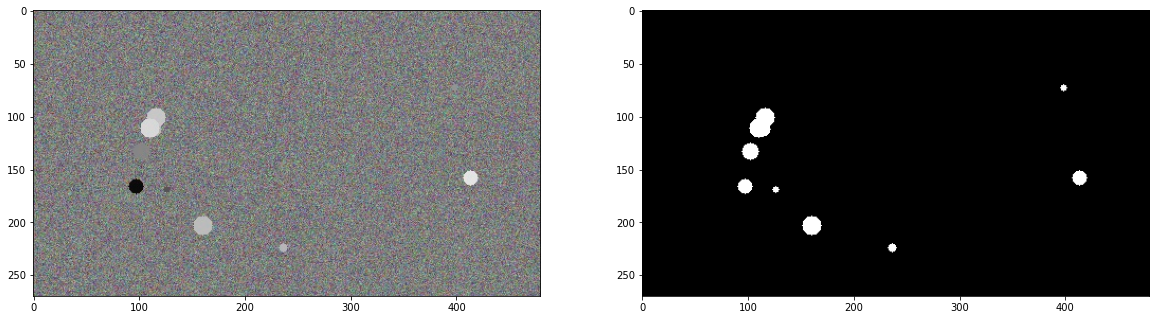

In [23]:
%matplotlib inline
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

idx = np.random.randint(0, num_samples)
img = cv2.imread(f'data/imgs/circles_{idx:03d}.jpg')
preds = cv2.imread(f'data/masks/circles_{idx:03d}.png') * 255
f, axarr = plt.subplots(1,2, figsize=(20,10)) 

axarr[0].imshow(img)
axarr[1].imshow(preds)

### 4.2) Upload the dataset to S3

In [ ]:
s3_train_uri = sess.upload_data(path='data/', key_prefix='datasets/circles')
print(f"Train s3 uri: {s3_train_uri}")

## 5) Train our model using a SageMaker Estimator for PyTorch

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train.py", # Specify your train script
    source_dir="src",
    role=role,
    sagemaker_session=sess,
    instance_count=1,
    instance_type='ml.g4dn.2xlarge',    
    disable_profiler=True,
    output_path=f"s3://{bucket}/output",
    framework_version='1.13.1',
    py_version='py39',
    
    volume_size = 64,
    hyperparameters={
        "learning-rate": 0.0003,
        "epochs": 20,
        "batch-size": 8,
        "classes": 2,
        "validation": 30
    },
    metric_definitions=[
        {'Name': 'train:loss', 'Regex': 'loss \(batch\)=(\S+)\]'},
        {'Name': 'dice:score', 'Regex': 'Validation Dice score: (\S+).'}
    ]
)

In [ ]:
estimator.fit({"train": s3_train_uri})

## 6) Create a custom inference file SageMaker will use to load/run our model

In [ ]:
%%writefile src/inference.py
import os
import io
import cv2
import torch
import numpy as np
from unet import UNet
from PIL import Image
from predict import predict_img, mask_to_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scale = 0.5
mask_threshold = 0.5
mask_values = [0,1]

def model_fn(model_dir, context=None):
    global device
    model_path = os.path.join(model_dir, 'model.pt')
    print(f"Model path: {model_path}")
    model = UNet(n_channels=3, n_classes=2, bilinear=False).to(device).eval()    
    state_dict = torch.load(model_path)
    state_dict.pop('mask_values', [0, 1])    
    model.load_state_dict(state_dict)
    return model

def input_fn(request_body, request_content_type, context=None):
    if request_content_type != 'image/jpeg':
        raise Exception(f"Unsupported mime type: {request_content_type}. Supported: image/jpeg")
    return Image.open(io.BytesIO(request_body))

def predict_fn(input_image, model, context=None):    
    global device, scale, mask_threshold, mask_values
    mask = predict_img(
        net=model, full_img=input_image, scale_factor=scale, out_threshold=mask_threshold, device=device
    )
    return mask

def output_fn(mask, accept, context=None):
    if accept!='image/jpeg':
        raise Exception(f'Invalid data type. Expected image/jpeg, got {accept}')

    mask_img = np.array(mask_to_image(mask, mask_values))[..., np.newaxis].astype(np.uint8)
    return cv2.imencode(".jpg", mask_img)[1].tobytes()

## 7) Deploy a SageMaker real-time endpoint

In [ ]:
pytorch_model = estimator.create_model(
    entry_point="inference.py", # Specify your train script
    source_dir="src",
    role=role,    
)

In [ ]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.g4dn.2xlarge',    
)

## 8) Now, we can invoke our model and run some experiments

In [ ]:
from sagemaker.serializers import DataSerializer
from sagemaker.deserializers import BytesDeserializer
predictor.serializer = DataSerializer(content_type='image/jpeg')
predictor.deserializer = BytesDeserializer(accept='image/jpeg')

Elapsed: 47.693729400634766ms


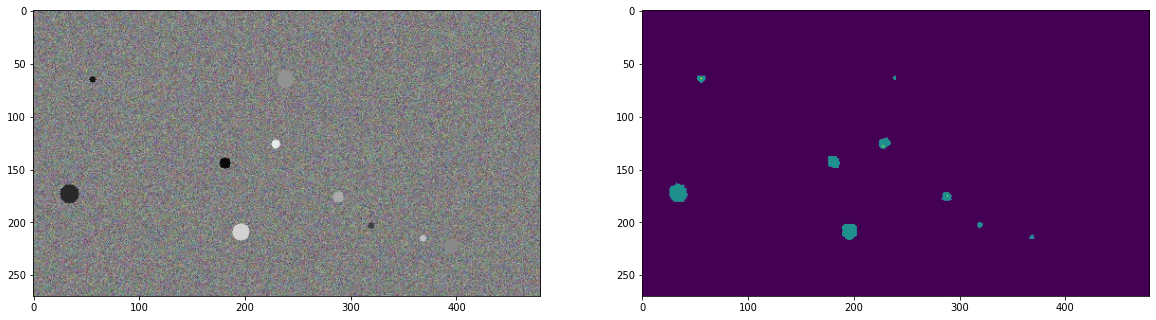

In [25]:
%matplotlib inline
import cv2
import time
import numpy as np
img_data = open(f'data/imgs/circles_{np.random.randint(0,10):03d}.jpg', 'rb').read()

img = cv2.imdecode(np.frombuffer(img_data, dtype=np.uint8), cv2.IMREAD_COLOR)
t = time.time()
mask = predictor.predict(img_data)
print(f"Elapsed: {(time.time()-t)*1000}ms")
mask = cv2.imdecode(np.frombuffer(mask, dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

f, axarr = plt.subplots(1,2, figsize=(20,10)) 

axarr[0].imshow(img)
axarr[1].imshow(mask)

## 9) Delete the endpoint

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()